In [1]:
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
from astroquery.vizier import Vizier

/Users/mbedell/python/TACS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from query_gaia import *

In [3]:
if False:
    vizier = Vizier(columns=['HIP', 'Teff', 'e_Teff', 'logg', 'e_logg', 'Fe/H', 'e_Fe/H'])
    vizier.ROW_LIMIT = 1000
    t_bensby = Table(vizier.get_catalogs("J/A+A/562/A71")[0])
    hips = np.array(['HIP'+str(h) for h in t_bensby['HIP']])
    t_bensby['source_id'] = get_dr3_sources_from_simbad(hips)
    t = query_gaia_astrophysical_parameters(t_bensby)
    t.write('bensby14_with_gaia.csv', overwrite=True)
else:
    t = Table.read('bensby14_with_gaia.csv')

In [4]:
print('{} failed Gaia matches'.format(np.sum([t['source_id_1'] == 0])))
# these all appear to be double stars where Gaia resolved both sources,
# so I think it's right to leave them out

8 failed Gaia matches


In [5]:
import json

with open("logg_correction.json", "r") as f:
    params = json.load(f)
m_logg,b_logg = params["m"], params["b"]

In [6]:
def fit_a_line_noerr(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, b

from scipy.odr import ODR, Model, RealData

def linear_func(B, x):
    return B[0]*x + B[1]

def fit_a_line(x,y,sigma_x,sigma_y):
    mask = y.mask # masked values to ignore
    linear_model = Model(linear_func)
    data = RealData(x[~mask], y[~mask], sx=sigma_x[~mask], sy=sigma_y[~mask])
    first_guess = fit_a_line_noerr(x[~mask],y[~mask])
    odr = ODR(data, linear_model, beta0=first_guess)
    output = odr.run()
    m, b = output.beta
    m_err, b_err = output.sd_beta
    return m,b

def save_params(filename, m, b):
    import json
    with open(filename, "w") as f:
        json.dump({"m": m, "b": b}, f)

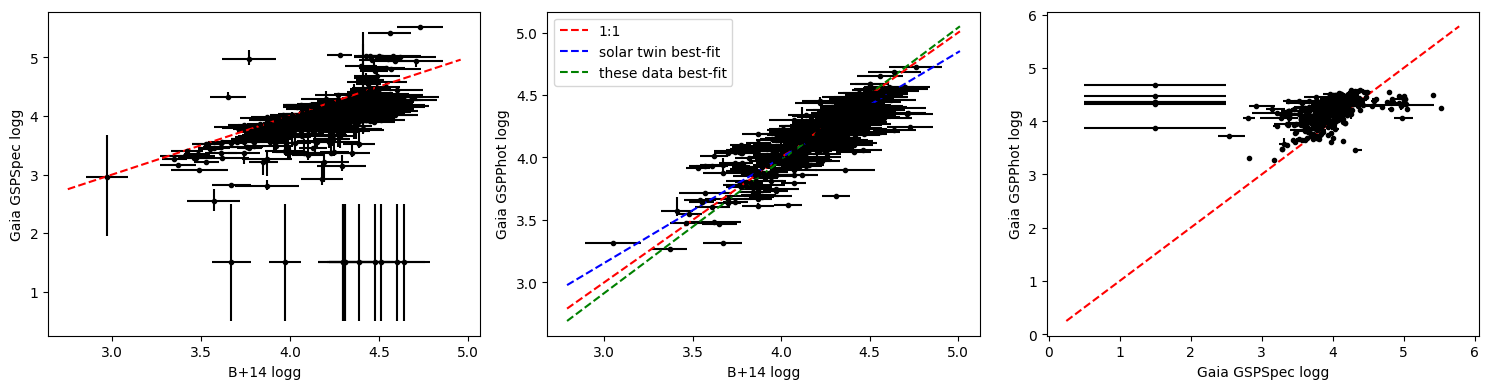

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].errorbar(t['logg'], t['logg_gspspec'], xerr=t['e_logg'], 
                 yerr=[t['logg_gspspec']-t['logg_gspspec_lower'],t['logg_gspspec_upper']-t['logg_gspspec']],
                 fmt='k.')
xl = axes[0].get_xlim()
axes[0].plot(xl, xl, 'r--', label='1:1')
axes[0].set_xlabel('B+14 logg')
axes[0].set_ylabel('Gaia GSPSpec logg')
axes[1].errorbar(t['logg'], t['logg_gspphot'], xerr=t['e_logg'], 
                 yerr=[t['logg_gspphot']-t['logg_gspphot_lower'],t['logg_gspphot_upper']-t['logg_gspphot']],
                 fmt='k.')
xl = axes[1].get_xlim()
axes[1].plot(xl, xl, 'r--', label='1:1')
t['logg_gspphot_avgerr'] = np.nanmean([t['logg_gspphot']-t['logg_gspphot_lower'],t['logg_gspphot_upper']-t['logg_gspphot']], axis=0)
m_logg2,b_logg2 = fit_a_line(t['logg'], t['logg_gspphot'], t['e_logg'], t['logg_gspphot_avgerr'])
axes[1].plot(xl, m_logg*np.array(xl)+b_logg, 'b--', label='solar twin best-fit')
axes[1].plot(xl, m_logg2*np.array(xl)+b_logg2, 'g--', label='these data best-fit')
axes[1].set_xlabel('B+14 logg')
axes[1].set_ylabel('Gaia GSPPhot logg')
axes[1].legend()
axes[2].errorbar(t['logg_gspspec'], t['logg_gspphot'], 
             xerr=[t['logg_gspspec']-t['logg_gspspec_lower'],t['logg_gspspec_upper']-t['logg_gspspec']],
             yerr=[t['logg_gspphot']-t['logg_gspphot_lower'],t['logg_gspphot_upper']-t['logg_gspphot']],
             fmt='k.')
xl = axes[2].get_xlim()
axes[2].plot(xl, xl, 'r--')
axes[2].set_xlabel('Gaia GSPSpec logg')
axes[2].set_ylabel('Gaia GSPPhot logg')
fig.tight_layout()
fig.savefig('bensby_comparison_logg.png');

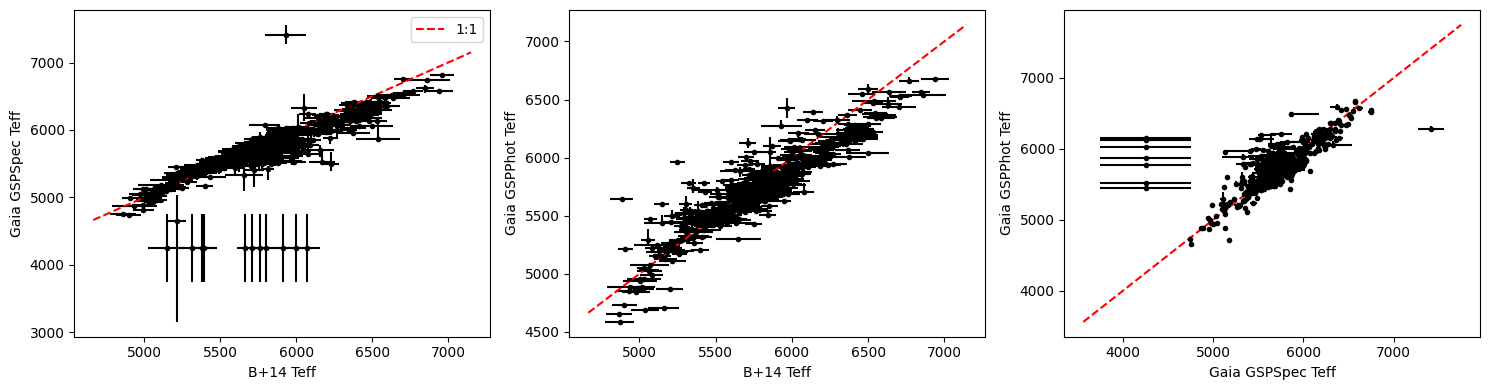

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].errorbar(t['Teff'], t['teff_gspspec'], xerr=t['e_Teff'], 
                 yerr=[t['teff_gspspec']-t['teff_gspspec_lower'],t['teff_gspspec_upper']-t['teff_gspspec']],
                 fmt='k.')
xl = axes[0].get_xlim()
axes[0].plot(xl, xl, 'r--', label='1:1')
axes[0].set_xlabel('B+14 Teff')
axes[0].set_ylabel('Gaia GSPSpec Teff')
axes[0].legend()
axes[1].errorbar(t['Teff'], t['teff_gspphot'], xerr=t['e_Teff'], 
                 yerr=[t['teff_gspphot']-t['teff_gspphot_lower'],t['teff_gspphot_upper']-t['teff_gspphot']],
                 fmt='k.')
xl = axes[1].get_xlim()
axes[1].plot(xl, xl, 'r--')
axes[1].set_xlabel('B+14 Teff')
axes[1].set_ylabel('Gaia GSPPhot Teff')
axes[2].errorbar(t['teff_gspspec'], t['teff_gspphot'], 
             xerr=[t['teff_gspspec']-t['teff_gspspec_lower'],t['teff_gspspec_upper']-t['teff_gspspec']],
             yerr=[t['teff_gspphot']-t['teff_gspphot_lower'],t['teff_gspphot_upper']-t['teff_gspphot']],
             fmt='k.')
xl = axes[2].get_xlim()
axes[2].plot(xl, xl, 'r--')
axes[2].set_xlabel('Gaia GSPSpec Teff')
axes[2].set_ylabel('Gaia GSPPhot Teff')
fig.tight_layout()
fig.savefig('bensby_comparison_teff.png');

In [9]:
with open("mh_correction.json", "r") as f:
    params = json.load(f)
m_mh,b_mh = params["m"], params["b"]

/Users/mbedell/python/TACS/.venv/lib/python3.9/site-packages/scipy/odr/_odrpack.py:392: RuntimeWarning: divide by zero encountered in divide
  return 1./numpy.power(sd, 2)


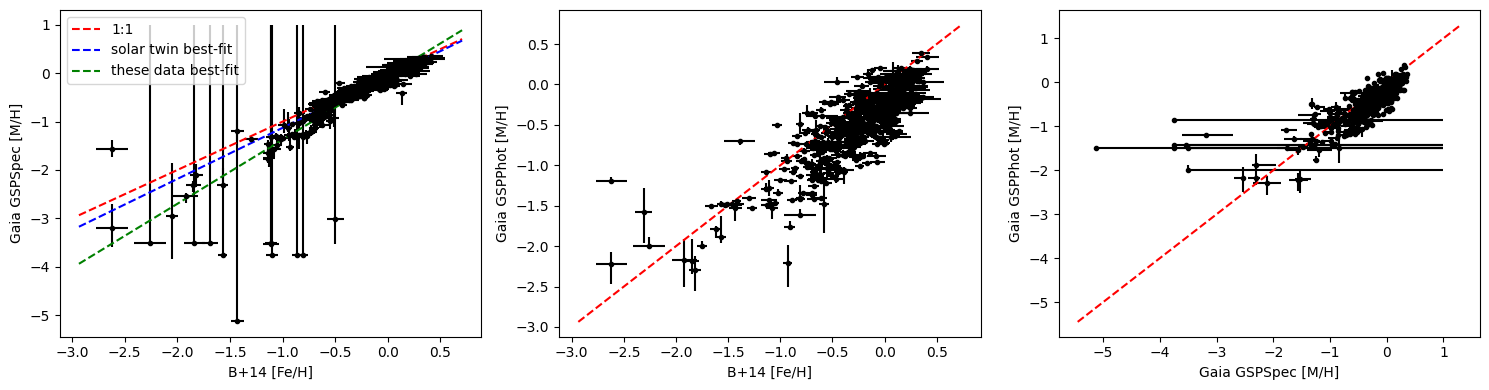

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].errorbar(t['Fe/H'], t['mh_gspspec'], xerr=t['e_Fe/H'], 
                 yerr=[t['mh_gspspec']-t['mh_gspspec_lower'],t['mh_gspspec_upper']-t['mh_gspspec']],
                 fmt='k.')
xl = axes[0].get_xlim()
axes[0].plot(xl, xl, 'r--', label='1:1')
t['mh_gspspec_avgerr'] = np.mean([t['mh_gspspec']-t['mh_gspspec_lower'],t['mh_gspspec_upper']-t['mh_gspspec']], axis=0)
m_mh2,b_mh2 = fit_a_line(t['Fe/H'], t['mh_gspspec'], t['e_Fe/H'], t['mh_gspspec_avgerr'])
axes[0].plot(xl, m_mh*np.array(xl)+b_mh, 'b--', label='solar twin best-fit')
axes[0].plot(xl, m_mh2*np.array(xl)+b_mh2, 'g--', label='these data best-fit')
axes[0].set_xlabel('B+14 [Fe/H]')
axes[0].set_ylabel('Gaia GSPSpec [M/H]')
axes[0].legend()
axes[1].errorbar(t['Fe/H'], t['mh_gspphot'], xerr=t['e_Fe/H'], 
                 yerr=[t['mh_gspphot']-t['mh_gspphot_lower'],t['mh_gspphot_upper']-t['mh_gspphot']],
                 fmt='k.')
xl = axes[1].get_xlim()
axes[1].plot(xl, xl, 'r--')
axes[1].set_xlabel('B+14 [Fe/H]')
axes[1].set_ylabel('Gaia GSPPhot [M/H]')
axes[2].errorbar(t['mh_gspspec'], t['mh_gspphot'], 
             xerr=[t['mh_gspspec']-t['mh_gspspec_lower'],t['mh_gspspec_upper']-t['mh_gspspec']],
             yerr=[t['mh_gspphot']-t['mh_gspphot_lower'],t['mh_gspphot_upper']-t['mh_gspphot']],
             fmt='k.')
xl = axes[2].get_xlim()
axes[2].plot(xl, xl, 'r--')
axes[2].set_xlabel('Gaia GSPSpec [M/H]')
axes[2].set_ylabel('Gaia GSPPhot [M/H]')
fig.tight_layout()
fig.savefig('bensby_comparison_mh.png');